# Starting, stopping, pre-pacing, and loops

In this example, we play with the [myokit.Simulation](https://myokit.readthedocs.io/api_simulations/Simulation.html) class a bit more, to see what happens when you start and re-start simulations, look at the `pre()` method, and use `reset()` to run several simulations in a loop.

In this example, we've used the epicardial version of [a model of the human ventricular AP](https://doi.org/10.1371/journal.pcbi.1002061) by O'Hara et al., you can download a copy [here](./models/ohara-2011-epi.mmt).

## Running repeated simulations

As before, we start by loading the model and its associated protocol, and creating a simulation:

In [3]:
import myokit
model, protocol, _ = myokit.load('models/ohara-2011-epi.mmt')

print('Loaded model: ' + model.name())

Loaded model: ohara-2011-epi


Next, we run a simulation and plot the results:

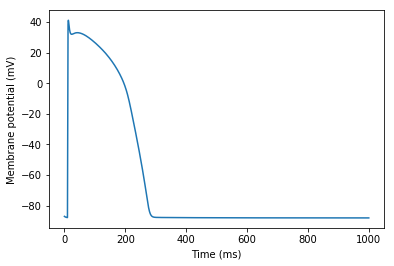

In [4]:
sim = myokit.Simulation(model, protocol)
log1 = sim.run(1000, log=['engine.time', 'membrane.V'])

import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.plot(log1['engine.time'], log1['membrane.V'])
plt.show()

Now we run a second simulation, and see what happens:

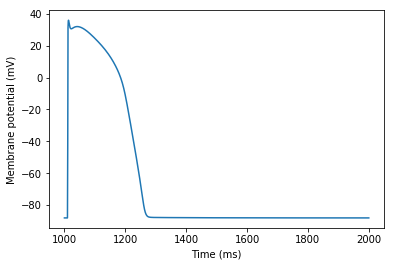

In [5]:
log2 = sim.run(1000, log=['engine.time', 'membrane.V'])

import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.plot(log2['engine.time'], log2['membrane.V'])
plt.show()

It looks very similar, but if look at the x-axis we can see that this second simulation starts at t=1000ms, so after the end of the first simulation.

We can stop and re-start simulations any time we like:

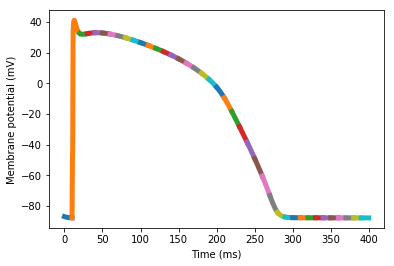

In [6]:
sim.reset()
plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
for i in range(40):
    log = sim.run(10, log=['engine.time', 'membrane.V'])
    plt.plot(log['engine.time'], log['membrane.V'], lw=5)
plt.show()

Returning back to the two AP example, we can also overlay the APs to compare their shape.
To do this, we subtract 1000ms from each logged time value in the second simulation.
This could be done in a for-loop, but we can also use [NumPy](https://numpy.org/) to create "array" objects from our logged simulation data. 
A quick way to convert our simulation results to NumPy arrays is to use the [npview()](https://myokit.readthedocs.io/api_simulations/DataLog.html#myokit.DataLog.npview) method:

In [7]:
# Initially, logs are array.array objects, that can be appended to by the simulation:
print('Before conversion:')
print(type(log2['membrane.V']))
print('After conversion:')
log2 = log2.npview()
print(type(log2['membrane.V']))

Before conversion:
<class 'array.array'>
After conversion:
<class 'numpy.ndarray'>


_(Note that we can now no longer use this DataLog for further simulation logging, as it has become a fixed-length object!)_

Having the results as a NumPy array means we can now easily manipulate the data, for example:

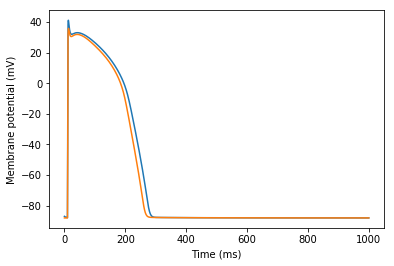

In [8]:
import matplotlib.pyplot as plt
plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.plot(log1['engine.time'], log1['membrane.V'])
plt.plot(log2['engine.time'] - 1000, log2['membrane.V'])
plt.show()

This shows us that the 2nd simulated AP differs from the first.
We can zoom in on the start of the simulations to get a hint why:

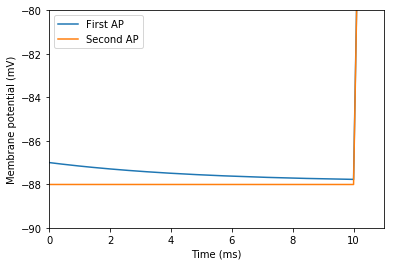

In [9]:
plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.plot(log1['engine.time'], log1['membrane.V'], label='First AP')
plt.plot(log2['engine.time'] - 1000, log2['membrane.V'], label='Second AP')
plt.xlim(0, 11)
plt.ylim(-90, -80)
plt.legend()
plt.show()

This shows us that the simulation's initial conditions have changed: The first AP was simulated from the model's default initial state, while the second AP was simulated from the state at the end of the first simulation.

We can return to the original initial conditions using [Simulation.reset()](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.reset):

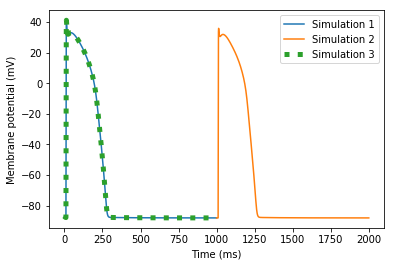

In [10]:
# Reset to original time and initial conditions
sim.reset()

# Run another simulation
log3 = sim.run(1000, log=['engine.time', 'membrane.V'])

# Plot all three simulations, without any modifications
plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.plot(log1['engine.time'], log1['membrane.V'], label='Simulation 1')
plt.plot(log2['engine.time'], log2['membrane.V'], label='Simulation 2')
plt.plot(log3['engine.time'], log3['membrane.V'], ':', lw=5, label='Simulation 3')
plt.legend()
plt.show()

So `reset()` has done two things:

1. It has reset the initial time back to t=0ms
2. It has returned the model to its _default state_


Note how there's three aspects involved here:

1. The simulation's _current time_ -- which we can get and set with [Simulation.time()](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.time) and [Simulation.set_time()](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.set_time).
2. The simulation's _current state_ -- which we can get and set with [Simulation.state()](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.state) and [Simulation.set_state()](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.set_state).
3. The simulation's _default state_ -- which we can get and set with [Simulation.default_state()](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.state) and [Simulation.set_default_state()](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.set_state).

So a call to `reset()` is the same as `sim.set_time(0)` followed by `sim.set_state(sim.default_state())`.




In the next parts of the example we show how these concepts come into play in everyday simulation work.

## Converging to a "steady state"

Let's have another look at the two APs we simulated earlier:

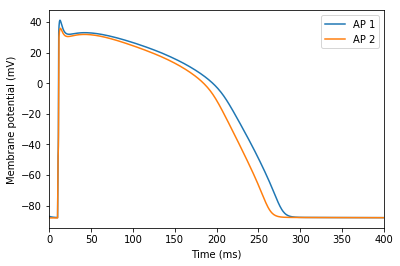

In [11]:
plt.figure()
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.plot(log1['engine.time'], log1['membrane.V'], label='AP 1')
plt.plot(log2['engine.time'] - 1000, log2['membrane.V'], label='AP 2')
plt.xlim(0, 400)
plt.legend()
plt.show()

By looking closely at the voltage at the start of the AP, we already saw that the initial states for both simulations had changed.
We can look in some more detail using [Simulation.state()](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.state) and [Model.format_state()](https://myokit.readthedocs.io/api_core/Model.html#myokit.Model.format_state):

In [12]:
# Reset to t=0 and the default state
sim.reset()

# Store the initial state
state1 = sim.state()

# Run a simulation
sim.run(1000, log=[])

# Store the state after 1000ms
state2 = sim.state()

# Use model.format_state to compare the two states
print(model.format_state(state1, state2))

membrane.V     = -87.0     -8.80076504892136171e+01
sodium.Nai     = 7.0        7.00067446890368128e+00
sodium.Na_ss   = 7.0        7.00072600161244729e+00
potassium.Ki   = 145.0      1.44993527823470686e+02
potassium.K_ss = 145.0      1.44993506382748052e+02
calcium.Cai    = 0.0001     6.02119095847466844e-05
calcium.Ca_ss  = 0.0001     5.99772637858751674e-05
calcium.Ca_nsr = 1.2        1.29189260405840423e+00
calcium.Ca_jsr = 1.2        1.24302541669008582e+00
ina.m          = 0.0        7.33987825743039318e-03
ina.hf         = 1.0        6.98306241328766175e-01
ina.hs         = 1.0        6.98297434951059337e-01
ina.j          = 1.0        6.98248553461674581e-01
ina.hsp        = 1.0        4.55215775788099908e-01
ina.jp         = 1.0        6.98215941392251183e-01
inal.m         = 0.0        1.88056369284993647e-04
inal.h         = 1.0        5.05735109034052943e-01
inal.hp        = 1.0        4.09773755951982510e-01
ito.a          = 0.0        1.00070754154014930e-03
ito.if      

This shows us all the model's state variables, their default values, and their values after the first simulation.
The first thing to notice is that default values in this case are all nice rounded numbers: it seems these were all set manually by the person who coded up the model!
Looking a bit closer at the state variables (and perhaps opening up the model definition file, and looking at the original paper!), we can see that the top rows all contain _concentrations_, which seem to have changed after the first beat.
We can run a long simulation and see what's going on:

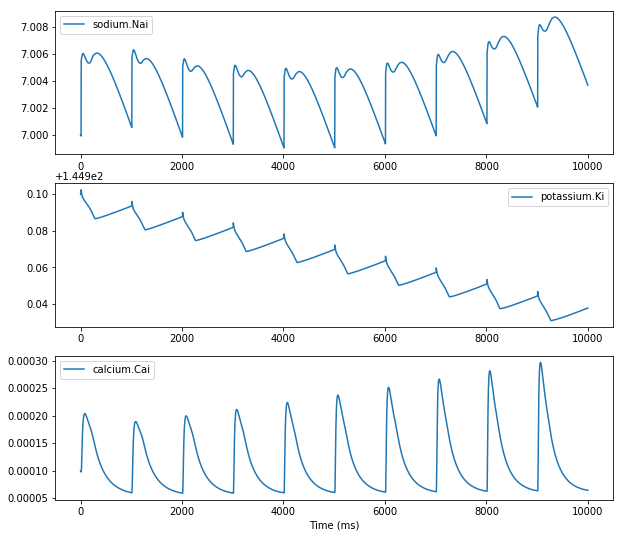

In [13]:
# Select a few concentrations for plotting:
concentrations = [
    'sodium.Nai',
    #'sodium.Na_ss',
    'potassium.Ki',
    #'potassium.K_ss',
    'calcium.Cai',
    #'calcium.Ca_ss',
    #'calcium.Ca_nsr',
    #'calcium.Ca_jsr',
]

# Simulate 10 beats (each 1000ms long)
sim.reset()
log = sim.run(10 * 1000, log=['engine.time'] + concentrations)

# Show how the concentrations change over time
n = len(concentrations)
plt.figure(figsize=(10, 9))
for i, variable in enumerate(concentrations):
    plt.subplot(n, 1, 1 + i)
    plt.plot(log['engine.time'], log[variable], label=variable)
    plt.legend()
plt.xlabel('Time (ms)')
plt.show()

So we can see the traces for the concentrations are _almost_, but not quite periodical.
They make roughly the same pattern every beat, but as they don't quite end up where they started when the next AP arrives, the system changes subtly from beat to beat.

We can run an even longer simulation to see what happens over time:

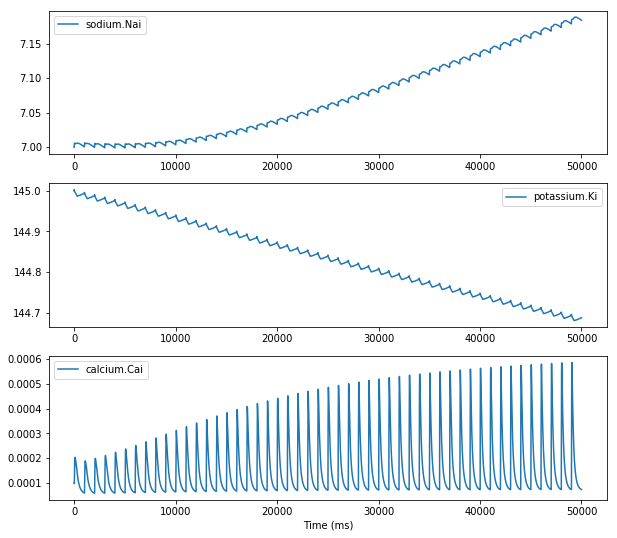

In [14]:
# Simulate 50 beats (each 1000ms long)
sim.reset()
log = sim.run(50 * 1000, log=['engine.time'] + concentrations)

# Show how the concentrations change over time
n = len(concentrations)
plt.figure(figsize=(10, 9))
for i, variable in enumerate(concentrations):
    plt.subplot(n, 1, 1 + i)
    plt.plot(log['engine.time'], log[variable], label=variable)
    plt.legend()
plt.xlabel('Time (ms)')
plt.show()

Oh dear!
The sodium concentration, which had been going down in the first 10 beats, has now started going up.
And the rate at which potassium levels are going down seems to be increasing.
Let's run an even longer simulation...

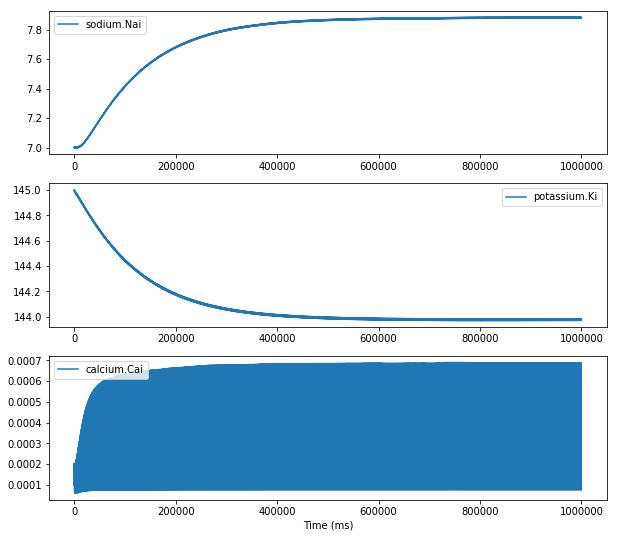

In [15]:
# Simulate 1000 beats (each 1000ms long)
sim.reset()
log = sim.run(1000 * 1000, log=['engine.time'] + concentrations)

# Show how the concentrations change over time
n = len(concentrations)
plt.figure(figsize=(10, 9))
for i, variable in enumerate(concentrations):
    plt.subplot(n, 1, 1 + i)
    plt.plot(log['engine.time'], log[variable], label=variable)
    plt.legend()
plt.xlabel('Time (ms)')
plt.show()

This looks a bit better!
It seems the concentrations for sodium and potassium have stabilised, although for calcium it's a bit harder to see what's going on.

At this scale, the periodic behaviour is very hard to see in the plot, so we can consider omitting it altogether by _only logging a single point in each beat_:

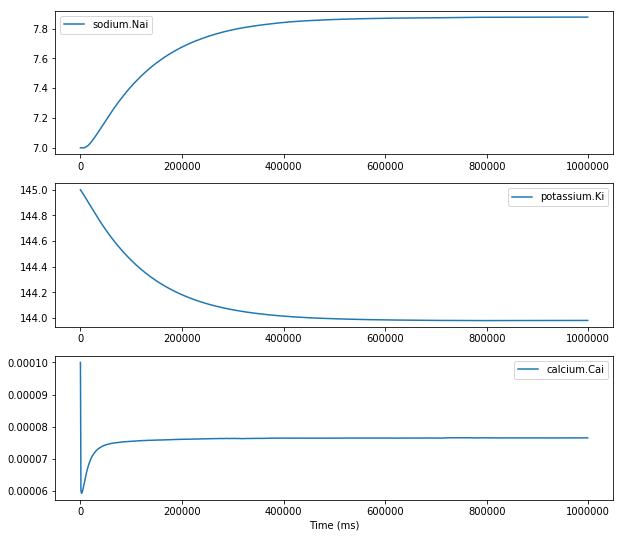

In [16]:
# Simulate 1000 beats (each 1000ms long), but only log one beat
sim.reset()
log = sim.run(
    1000 * 1000, 
    log=['engine.time'] + concentrations, 
    log_interval=1000)

# Show how the concentrations change over time
n = len(concentrations)
plt.figure(figsize=(10, 9))
for i, variable in enumerate(concentrations):
    plt.subplot(n, 1, 1 + i)
    plt.plot(log['engine.time'], log[variable], label=variable)
    plt.legend()
plt.xlabel('Time (ms)')
plt.show()

So it looks like the concentrations have stabilised at this point: they still vary _during_ each beat, but they return to the same value at the end of every beat.

_(More complicated things can also happen. For example you can arrive in a situation where the system alternates between two similar beats. This is called "alternans" and has been shown to occur in real cells as well as models. It's usually related to variations in the Calcium concentration.)_

In cardiac electrophysiology, we say that the model is now in _steady state_.
If a mathematician is listening, it's better to say the system has _converged to a periodic orbit_: it still varies all the time, but the system's _orbit_ through state space has converged to a periodic one.
We saw above that the system has quite a lot of state variables, so this orbit is hard to visualise, but we can at least plot "slices" of it, to see that this is the case:

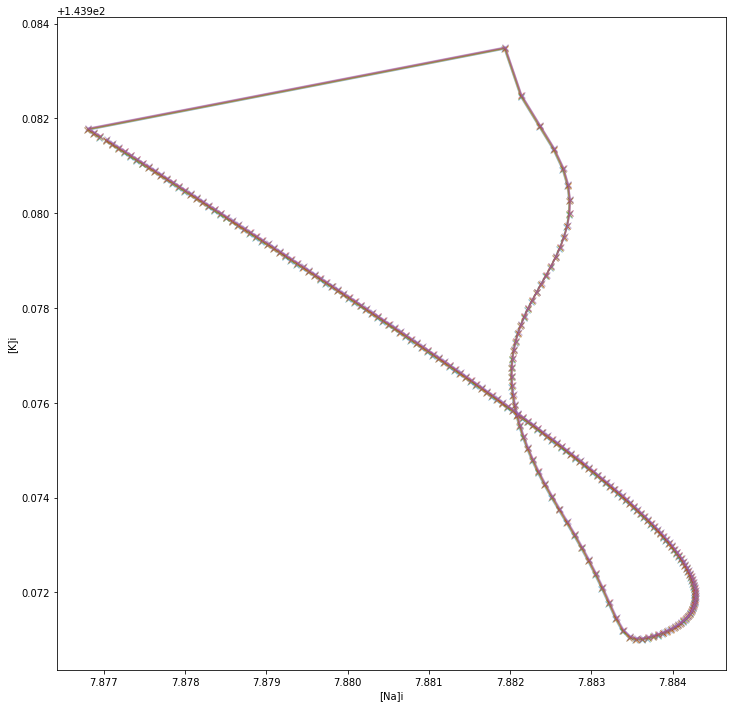

In [17]:
# Simulate a few beats, starting at the end of the previous simulation
plt.figure(figsize=(12, 12))
plt.xlabel('[Na]i')
plt.ylabel('[K]i')
for i in range(5):
    log = sim.run(
        1000,
        log=['engine.time'] + concentrations,
        log_interval=5
    )
    plt.plot(log['sodium.Nai'], log['potassium.Ki'], 'x-', alpha=0.5)
plt.show()


The first thing you might notice is that the "orbit" shown here is quite complex!
Action potentials are not very simple systems.

Another thing you can clearly see in this graph is the straight line at the top: this corresponds to the rhythmic _pacing_ that is applied to this model, and the subsequent upstroke.

Finally, note that the lines from the 10 simulations are almost identical, making it hard to distinguish them.
However, the line still looks somewhat blurry, showing that there is still some adaptation going on from beat to beat.

There's a lot of questions you might want to ask at this point:

1. Has the system really reached a "steady state"? Or will it start diverging from the periodic orbit at some point?
2. Does every model have such a steady state? And is there a single steady state or will we end up in different places depending on the initial conditions?
3. Are there clever ways to find these "steady states" or "periodic orbits", or do we just need to simulate for a long time?
4. Most importantly, is this something that happens only in models, or is it a feature of real cells?

Some notable studies that touch on the 2nd question include [Endresen et al., 2000](https://doi.org/10.1007/s002490050254) and [Hund et al., 2001](https://doi.org/10.1016/S0006-3495(01)75965-6), which both focus on calculating the membrane potential from the concentrations directly, and [Livshitz & Rudy, 2009](https://doi.org/10.1016/j.bpj.2009.05.062), which looks at the role of the stimulus current and conservation of charge.

In the majority of cases though, modellers have taken a practical approach and simply "pre-paced" the model to something approximating a steady state, before running further experiments.

## Pre-pacing AP models

Because pre-pacing is so common, Myokit's simulations have a method [pre()](https://myokit.readthedocs.io/api_simulations/Simulation.html#myokit.Simulation.pre) for pre-pacing.

Like the run() method, pre() takes a _duration_ as its input, for example:

In [22]:
# Load a model, protocol, and script
model, protocol, _ = myokit.load('models/ohara-2011-epi.mmt')

# Create a simulation
sim = myokit.Simulation(model, protocol)

# Pre-pace for 500s
sim.pre(500 * 1000)

There are three major differences from run():

- The pre() method does not do any logging (making this a lot faster), and does not return a DataLog.
- The pre() **does not** affect the simulation time.
- The pre() method updates **both the state and the default state**.

We can check the second two differences:

In [23]:
# The time is still 0ms
print(sim.time())

0


In [24]:
# The default state has been updated, and is no longer set to the user-defined original values:
print(model.format_state(sim.default_state(), sim.state()))

membrane.V     = -8.79364892884202050e+01    -8.79364892884202050e+01
sodium.Nai     =  7.86089732326276636e+00     7.86089732326276636e+00
sodium.Na_ss   =  7.86097953808315175e+00     7.86097953808315175e+00
potassium.Ki   =  1.43994672378664461e+02     1.43994672378664461e+02
potassium.K_ss =  1.43994639983648710e+02     1.43994639983648710e+02
calcium.Cai    =  7.65159695017084829e-05     7.65159695017084829e-05
calcium.Ca_ss  =  7.55188987647993913e-05     7.55188987647993913e-05
calcium.Ca_nsr =  2.00006080298817457e+00     2.00006080298817457e+00
calcium.Ca_jsr =  1.94128931500693014e+00     1.94128931500693014e+00
ina.m          =  7.39259080014664175e-03     7.39259080014664175e-03
ina.hf         =  6.95837191283437351e-01     6.95837191283437351e-01
ina.hs         =  6.95826497741037886e-01     6.95826497741037886e-01
ina.j          =  6.95764671806865631e-01     6.95764671806865631e-01
ina.hsp        =  4.52310178069198932e-01     4.52310178069198932e-01
ina.jp         =  6.

Because the default state has changed, subsequent calls to reset() will reset the simulation **to the last state reached by pre()**.

## Running simulations in a loop

Using `pre()`, `reset()`, and `run()` we now have the tools to explore the effects of varying model parameters.

In the next example we:

1. pre-pace the model to a quasi-steady state
2. modify the model's IKr conductance, set by the variable `ikr.GKr`
3. run _another_ series of unlogged beats, this time with run()
4. plot an AP
5. reset the simulation to the sitatuation at the end of step 1, and repeat starting from step 2


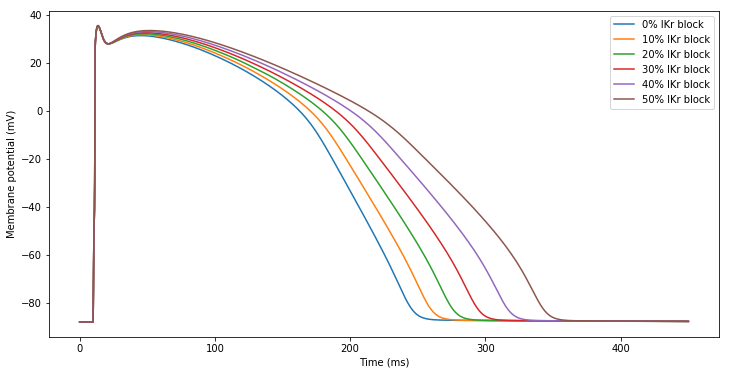

In [30]:
# Load a model, protocol, and script
model, protocol, _ = myokit.load('models/ohara-2011-epi.mmt')

# Create a simulation
sim = myokit.Simulation(model, protocol)

# Pre-pace 500 beats
sim.pre(500 * 1000)

# Create a figure
plt.figure(figsize=(12, 6))
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')

# Explore parameter variation
levels = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5]
for level in levels:
    # Reset to state after initial pre-pacing
    sim.reset()
    
    # Modify IKr conductance
    sim.set_constant('ikr.GKr', level * 0.0598)
    
    # Calculate percentage block, for display
    block = round(100 * (1 - level))
    
    # Pre-pace for the adapted level
    sim.run(50 * 1000, log=[])
    sim.set_time(0)
    
    # Plot AP
    log = sim.run(450, log=['engine.time', 'membrane.V'])
    plt.plot(log['engine.time'], log['membrane.V'], label=str(block) + '% IKr block')

# Show results
plt.legend()
plt.show()

Note that, while we're pre-pacing now, in this example we don't actually check whether the pre-pacing has had the desired effect. 
To do this, we could simulate another beat (after `sim.run(50 * 1000, log=[])`) and e.g.

- compare the result of `sim.state()` before and after the beat, or
- log and compare two action potentials.

If you write a good method to do this, you could consider [adding it to Myokit](https://github.com/MichaelClerx/myokit/issues/390)!